In [3]:
from neo4j import GraphDatabase
import pandas as pd
from tqdm import tqdm
import plotly
import plotly.express as px
import plotly.io as pio
from upsetplot import plot
from matplotlib import pyplot as plt
import plotly.graph_objects as go


## Harmonizing Different Evidence Statement Types in MetaKB v2
The first take at this analysis utilized just broad statements with attached therapeutics with no regard for the statement type. (To be honest, I don't think it even had a notion of a type at the time.)  
  
For this notebook, we will retrieve study statements and perform an analysis that looks at uniqueness by resource across different categories of evidence (as defined by va-spec). Additionally, I am going to try to pipeline this notebook to automatically run all of it with a single button.

TODO: Variants for Uniqueness. Also, full sections for Concordance, Interpretability.

### Table of Contents
* [Data Retrieval](evidence.ipynb#data-retrieval)
    * [Get Study Statements](#get-study-statements)
    * [Additional Queries](#additional-queries)
    * [Additional Functions](#additional-functions)
* [Variant Prognostic Study Statements](#variant-prognostic-study-statements)
    * [Initialize Data](#prognostic-init)
    * [Uniqueness](#'prognostic-unique-statement')
* [Variant Therapeutic Response Study Statements](#variant-therapeutic-response-study-statements)
    * [Initialize Data](#'therapeutic-response-init')
    * [Uniqueness](#'therapeutic-response-unique')
    * [Concordance](#concordance)
* [Variant Diagnostic Study Statements](#variant-diagnostic-study-statements) *not implemented*
* [Variant Oncogenicity Study Statements](#variant-oncogenicity-study-statements) *not implemented*
* [Cohort Allele Frequency Study Statements](#cohort-allele-frequency-study-statements) *not implemented*
* [Experimental Variant Functional Impact Study Statements](#experimental-variant-functional-impact-study-statements) *not implemented*
* [Individual Concept Uniqueness](#individual-concept-uniqueness)
    * [Diseases](#diseases)
    * [Genes](#genes)
    * [Therapies](#therapies)
    * [Variants](#variants)
    * [All Plot](#all-plot)
<a id='toc'></a>

## Data Retrieval


### Get Study Statements

In [27]:
def create_db_connection(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    return driver

def execute_query(query):
    uri = "bolt://localhost:7687"
    user = "neo4j"
    password = "password"
    driver = create_db_connection(uri, user, password)
    with driver.session() as session:
        result = session.run(query)
        data = [record for record in result]
    driver.close()
    return data
    
# Queries
q_all_statements = """MATCH (s:StudyStatement)
    RETURN properties(s) AS Study
"""

# Run Query
result = execute_query(q_all_statements)


In [28]:
data = []
for record in result:
    study = record.get('Study', {})
    row = {
        'id': study.get('id', None),
        'studyType': study.get('type',None),
        'propositionType': study.get('propositionType',None),
        'description': study.get('description', None),
        'alleleOriginQualifier': study.get('alleleOriginQualifier',None),
        'direction': study.get('direction',None),
        'predicate': study.get('predicate', None)
    }
    data.append(row)

df = pd.DataFrame(data)

df

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate
0,civic.eid:238,Statement,VariantTherapeuticResponseProposition,The T790M mutation in EGFR has been shown to c...,somatic,supports,predictsResistanceTo
1,civic.eid:1409,Statement,VariantTherapeuticResponseProposition,Phase 3 randomized clinical trial comparing ve...,somatic,supports,predictsSensitivityTo
2,civic.eid:1592,Statement,VariantTherapeuticResponseProposition,Osimertinib has been approved for the treatmen...,somatic,supports,predictsSensitivityTo
3,civic.eid:1867,Statement,VariantTherapeuticResponseProposition,"Randomized, international, open-label, phase 3...",somatic,supports,predictsSensitivityTo
4,civic.eid:2994,Statement,VariantTherapeuticResponseProposition,"On May 14, 2013, the U.S. Food and Drug Admini...",somatic,supports,predictsSensitivityTo
...,...,...,...,...,...,...,...
1295,moa.assertion:991,Statement,VariantTherapeuticResponseProposition,The U.S. Food and Drug Administration (FDA) gr...,somatic,supports,predictsSensitivityTo
1296,moa.assertion:993,Statement,VariantTherapeuticResponseProposition,The U.S. Food and Drug Administration (FDA) gr...,somatic,supports,predictsSensitivityTo
1297,moa.assertion:996,Statement,VariantTherapeuticResponseProposition,The U.S. Food and Drug Administration (FDA) gr...,somatic,supports,predictsSensitivityTo
1298,moa.assertion:999,Statement,VariantTherapeuticResponseProposition,The U.S. Food and Drug Administration (FDA) gr...,somatic,supports,predictsSensitivityTo


In [185]:
df['propositionType'].value_counts()

propositionType
VariantTherapeuticResponseProposition    1099
VariantPrognosticProposition              156
VariantDiagnosticProposition               45
Name: count, dtype: int64

### Additional Queries
These will be used to fill in additional data from retrieved nodes as dependent on the study type.

In [ ]:
def grab_subject_variant(study_id):
    query = f"""MATCH (s:StudyStatement) WHERE s.id = '{study_id}'
        MATCH (s)-[:HAS_VARIANT]-(c)
        MATCH (c)-[:HAS_DEFINING_CONTEXT]-(v)
        RETURN properties(s) AS Study,
                properties(c) AS Variation,
                properties(v) AS Context
    """
    result = execute_query(query)
    if len(result) > 1:
        print(f'{study_id} has {len(result)} subjects possible')
    subject = result[0]['Context']['id']
    return(subject)

def grab_object_therapeutic(study_id): 
    query = f"""MATCH (s:StudyStatement) WHERE s.id = '{study_id}'
        MATCH (s)-[:HAS_THERAPEUTIC]-(c)
        RETURN properties(s) AS Study,
                properties(c) AS Therapeutic
    """
    result = execute_query(query)
    if len(result) > 1:
        print(f'{study_id} has {len(result)} subjects possible')

    # Check for empty result
    if not(result): 
        return(None)

    # Grab concept identifier (if not single therapeutic, handle other cases)
    if 'normalizer_id' in result[0]['Therapeutic']:
        therapeutic = result[0]['Therapeutic']['normalizer_id']
        return(therapeutic)
    
    if 'groupType' in result[0]['Therapeutic'].keys():
        ther_type = result[0]['Therapeutic']['groupType']
        return((ther_type, result[0]['Therapeutic']['id']))    

def grab_qualifier_disease(study_id): 
    query = f"""MATCH (s:StudyStatement) WHERE s.id = '{study_id}'
        MATCH (s)-[:HAS_TUMOR_TYPE]-(c)
        RETURN properties(s) AS Study,
                properties(c) AS Disease
    """
    result = execute_query(query)
    if len(result) > 1:
        print(f'{study_id} has {len(result)} subjects possible')
    
    try: # TODO: This id should be normalizer_id not disease_normalizer_id. Will likely need to redo analysis
        disease = result[0]['Disease']['disease_normalizer_id']
    except: # TODO: This is gross, handle it better
        try:
            disease = result[0]['Disease']['label']
        except:
            disease = result[0]['Disease']['id']
    return(disease)


### Additional Functions

In [86]:
def calculate_uniqueness(test_df,reference_df,column_prefix):
    sources = list(reference_df['source'].unique())
    for idx, row in tqdm(test_df.iterrows()):
        current_value = test_df.at[idx,f'{column_prefix}s']
        for source in sources:
            tdf = reference_df[reference_df['source']==source]
            if current_value in list(tdf[f'{column_prefix}'].unique()):
                test_df.at[idx,source] = True
            elif current_value not in list(tdf[f'{column_prefix}'].unique()):
                test_df.at[idx,source] = False
            else:
                test_df.at[idx,source] = 'Something went wrong'       
            pass
        pass
    return(test_df)

def format_for_upset(test_df,column_prefix):
    test_df.set_index(f'{column_prefix}s', inplace=True)
    for col in test_df:
        test_df[col] = test_df[col].astype(bool)
    upset_data = test_df.groupby(list(test_df.columns)).size()
    return(upset_data)

def count_predicate_occurrences(df):
    value_counts = df['predicate'].value_counts()
    predicate_counts = value_counts.to_dict()
    predicate_counts['total'] = value_counts.sum()
    return predicate_counts

def calculate_agreement_metric(predicate_counts):
    total_count = predicate_counts['total']    
    max_count = max([count for predicate, count in predicate_counts.items() if predicate != 'total'])
    agreement_metric = (max_count / total_count)
    return agreement_metric

[Back to Top](#table-of-contents)

## Variant Prognostic Study Statements



### Initialize Data
<a id='prognostic-init'></a>

In [187]:
data = df[df['propositionType']=='VariantPrognosticProposition'].reset_index(drop=True)
print(f'Studies found: {len(data)}')
data[0:5]

Studies found: 156


,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate
0,civic.eid:102,Statement,VariantPrognosticProposition,Unlike other studies that suggest a poorer out...,somatic,disputes,associatedWithWorseOutcomeFor
1,civic.eid:103,Statement,VariantPrognosticProposition,V600E is associated with adverse pathological ...,somatic,supports,associatedWithWorseOutcomeFor
2,civic.eid:656,Statement,VariantPrognosticProposition,In patients with papillary thyroid cancer harb...,somatic,supports,associatedWithWorseOutcomeFor
3,civic.eid:1420,Statement,VariantPrognosticProposition,Study examined rare SNPs on MAP2K7 among a dis...,germline,supports,associatedWithWorseOutcomeFor
4,civic.eid:26,Statement,VariantPrognosticProposition,"In acute myloid leukemia patients, D816 mutati...",somatic,supports,associatedWithWorseOutcomeFor


In [188]:
data[['Variant','Disease']] = None 
data['Variant'] = data['id'].apply(grab_subject_variant)
data['Disease'] = data['id'].apply(grab_qualifier_disease)
data[0:5]

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate,Variant,Disease
0,civic.eid:102,Statement,VariantPrognosticProposition,Unlike other studies that suggest a poorer out...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma
1,civic.eid:103,Statement,VariantPrognosticProposition,V600E is associated with adverse pathological ...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Colorectal Cancer
2,civic.eid:656,Statement,VariantPrognosticProposition,In patients with papillary thyroid cancer harb...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma
3,civic.eid:1420,Statement,VariantPrognosticProposition,Study examined rare SNPs on MAP2K7 among a dis...,germline,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nE0U2q_0hSEFMnTRq7MM3ZrVByPOuTdE,Lung Cancer
4,civic.eid:26,Statement,VariantPrognosticProposition,"In acute myloid leukemia patients, D816 mutati...",somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nhiDwIq1klrGm3wtWO4a4BiS0jdW79Wd,Acute Myeloid Leukemia


In [189]:
data['source'] = data['id'].apply(lambda x: x.split('.')[0])
data['statement'] = data.apply(lambda row: (row['Variant'], row['predicate'], row['Disease']), axis=1) #TODO: Normalize diseases?
data

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate,Variant,Disease,source,statement
0,civic.eid:102,Statement,VariantPrognosticProposition,Unlike other studies that suggest a poorer out...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
1,civic.eid:103,Statement,VariantPrognosticProposition,V600E is associated with adverse pathological ...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Colorectal Cancer,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
2,civic.eid:656,Statement,VariantPrognosticProposition,In patients with papillary thyroid cancer harb...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
3,civic.eid:1420,Statement,VariantPrognosticProposition,Study examined rare SNPs on MAP2K7 among a dis...,germline,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nE0U2q_0hSEFMnTRq7MM3ZrVByPOuTdE,Lung Cancer,civic,"(ga4gh:VA.nE0U2q_0hSEFMnTRq7MM3ZrVByPOuTdE, as..."
4,civic.eid:26,Statement,VariantPrognosticProposition,"In acute myloid leukemia patients, D816 mutati...",somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nhiDwIq1klrGm3wtWO4a4BiS0jdW79Wd,Acute Myeloid Leukemia,civic,"(ga4gh:VA.nhiDwIq1klrGm3wtWO4a4BiS0jdW79Wd, as..."
...,...,...,...,...,...,...,...,...,...,...,...
151,moa.assertion:931,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.bmYmmyJlyeM405Fw6sLMP42VVWbChRJj,Myelodysplasia,moa,"(ga4gh:VA.bmYmmyJlyeM405Fw6sLMP42VVWbChRJj, as..."
152,moa.assertion:932,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.NaCpxzfdn882A-Ad05GWU0TTs9WmKLMg,Myelodysplasia,moa,"(ga4gh:VA.NaCpxzfdn882A-Ad05GWU0TTs9WmKLMg, as..."
153,moa.assertion:933,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x,Myelodysplasia,moa,"(ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x, as..."
154,moa.assertion:934,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x,Myelodysplasia,moa,"(ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x, as..."


In [190]:
data['statement'].value_counts()

statement
(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, associatedWithWorseOutcomeFor, Papillary Thyroid Carcinoma)             8
(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, associatedWithWorseOutcomeFor, Colorectal Cancer)                       7
(ga4gh:VA.uOzCG-Blg0EEZfX9z2ZxvpGcWp7r2NrI, associatedWithWorseOutcomeFor, Spindle Cell Rhabdomyosarcoma)           4
(ga4gh:VA.5GEqm-zIzvvPheyGb9rlu5DyIueIubXm, associatedWithBetterOutcomeFor, Breast Cancer)                          2
(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, associatedWithWorseOutcomeFor, Melanoma)                                2
                                                                                                                   ..
(ga4gh:VA.cdcXITbBWUXPjy3zPdhs7xjU1yvlkSrj, associatedWithWorseOutcomeFor, Pancreatic Ductal Carcinoma)             1
(ga4gh:VA.6xzzXheebNYrE6lgDlRK2XN0NHrnoyOg, associatedWithWorseOutcomeFor, Neuroblastoma)                           1
(ga4gh:VA.cdcXITbBWUXPjy3zPdhs7xjU1yvlkSrj, as

### Uniqueness (Statement Level)
<a id='prognostic-unique-statement'></a>

129it [00:00, 1273.32it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

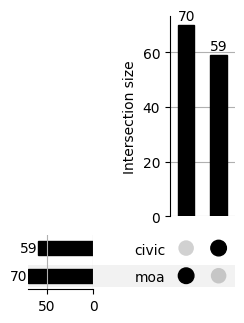

In [ ]:
# Initialize unique groups for identifying uniqueness
unique_prognostic_statements = list(data['statement'].unique())

prognostic_statement_uniqueness = pd.DataFrame({'statements': unique_prognostic_statements,
                                                'civic': None,
                                                'moa': None})

prognostic_statement_uniqueness = calculate_uniqueness(prognostic_statement_uniqueness, data,'statement')
upset_data = format_for_upset(prognostic_statement_uniqueness,'statement')
plot(upset_data, show_counts=True)
# plt.savefig('gene_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [192]:
data

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate,Variant,Disease,source,statement
0,civic.eid:102,Statement,VariantPrognosticProposition,Unlike other studies that suggest a poorer out...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
1,civic.eid:103,Statement,VariantPrognosticProposition,V600E is associated with adverse pathological ...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Colorectal Cancer,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
2,civic.eid:656,Statement,VariantPrognosticProposition,In patients with papillary thyroid cancer harb...,somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Papillary Thyroid Carcinoma,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, as..."
3,civic.eid:1420,Statement,VariantPrognosticProposition,Study examined rare SNPs on MAP2K7 among a dis...,germline,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nE0U2q_0hSEFMnTRq7MM3ZrVByPOuTdE,Lung Cancer,civic,"(ga4gh:VA.nE0U2q_0hSEFMnTRq7MM3ZrVByPOuTdE, as..."
4,civic.eid:26,Statement,VariantPrognosticProposition,"In acute myloid leukemia patients, D816 mutati...",somatic,supports,associatedWithWorseOutcomeFor,ga4gh:VA.nhiDwIq1klrGm3wtWO4a4BiS0jdW79Wd,Acute Myeloid Leukemia,civic,"(ga4gh:VA.nhiDwIq1klrGm3wtWO4a4BiS0jdW79Wd, as..."
...,...,...,...,...,...,...,...,...,...,...,...
151,moa.assertion:931,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.bmYmmyJlyeM405Fw6sLMP42VVWbChRJj,Myelodysplasia,moa,"(ga4gh:VA.bmYmmyJlyeM405Fw6sLMP42VVWbChRJj, as..."
152,moa.assertion:932,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.NaCpxzfdn882A-Ad05GWU0TTs9WmKLMg,Myelodysplasia,moa,"(ga4gh:VA.NaCpxzfdn882A-Ad05GWU0TTs9WmKLMg, as..."
153,moa.assertion:933,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x,Myelodysplasia,moa,"(ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x, as..."
154,moa.assertion:934,Statement,VariantPrognosticProposition,The National Comprehensive Cancer Network® (NC...,somatic,disputes,associatedWithWorseOutcomeFor,ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x,Myelodysplasia,moa,"(ga4gh:VA.YZB-axAEhDjlTdXQOT9yd2MWc_01Zo0x, as..."


[Back to Top](#table-of-contents)


### Uniqueness (Concept Level)

109it [00:00, 2760.74it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

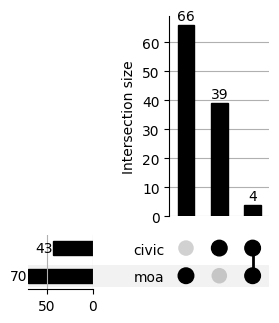

In [193]:
# TODO: Move this to the individual concepts at the end, add it to the graph. Also redo how calling the variants
# Initialize unique groups for identifying uniqueness
unique_prognostic_variants = list(data['Variant'].unique())

prognostic_variant_uniqueness = pd.DataFrame({'Variants': unique_prognostic_variants,
                                                'civic': None,
                                                'moa': None})

prognostic_variant_uniqueness = calculate_uniqueness(prognostic_variant_uniqueness, data,'Variant')
# prognostic_proportions = gene_uniqueness # TODO: Do we need this for the statement level? might just be good for broad concepts
upset_data = format_for_upset(prognostic_variant_uniqueness,'Variant')
plot(upset_data, show_counts=True)
# plt.savefig('gene_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()
# TODO: Maybe we only care about this at the whole database level? for individual concepts that is 

## Variant Therapeutic Response Study Statements

### Initialize Data
<a id='therapeutic-response-init'></a>

In [31]:
data = df[df['propositionType']=='VariantTherapeuticResponseProposition'].reset_index(drop=True)
print(f'Studies found: {len(data)}')
data[0:5]

Studies found: 1099


,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate
0,civic.eid:238,Statement,VariantTherapeuticResponseProposition,The T790M mutation in EGFR has been shown to c...,somatic,supports,predictsResistanceTo
1,civic.eid:1409,Statement,VariantTherapeuticResponseProposition,Phase 3 randomized clinical trial comparing ve...,somatic,supports,predictsSensitivityTo
2,civic.eid:1592,Statement,VariantTherapeuticResponseProposition,Osimertinib has been approved for the treatmen...,somatic,supports,predictsSensitivityTo
3,civic.eid:1867,Statement,VariantTherapeuticResponseProposition,"Randomized, international, open-label, phase 3...",somatic,supports,predictsSensitivityTo
4,civic.eid:2994,Statement,VariantTherapeuticResponseProposition,"On May 14, 2013, the U.S. Food and Drug Admini...",somatic,supports,predictsSensitivityTo


In [32]:
data[['Variant','Disease','Therapeutic']] = None 
data['Variant'] = data['id'].apply(grab_subject_variant)
data['Disease'] = data['id'].apply(grab_qualifier_disease)
data['Therapeutic'] = data['id'].apply(grab_object_therapeutic)
data['source'] = data['id'].apply(lambda x: x.split('.')[0])
data['statement'] = data.apply(lambda row: (row['Variant'], row['predicate'], row['Therapeutic'], row['Disease']), axis=1)
data

data[0:5]

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate,Variant,Disease,Therapeutic,source,statement
0,civic.eid:238,Statement,VariantTherapeuticResponseProposition,The T790M mutation in EGFR has been shown to c...,somatic,supports,predictsResistanceTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,337525,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr..."
1,civic.eid:1409,Statement,VariantTherapeuticResponseProposition,Phase 3 randomized clinical trial comparing ve...,somatic,supports,predictsSensitivityTo,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Skin Melanoma,1147220,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, pr..."
2,civic.eid:1592,Statement,VariantTherapeuticResponseProposition,Osimertinib has been approved for the treatmen...,somatic,supports,predictsSensitivityTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,1721560,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr..."
3,civic.eid:1867,Statement,VariantTherapeuticResponseProposition,"Randomized, international, open-label, phase 3...",somatic,supports,predictsSensitivityTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,1721560,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr..."
4,civic.eid:2994,Statement,VariantTherapeuticResponseProposition,"On May 14, 2013, the U.S. Food and Drug Admini...",somatic,supports,predictsSensitivityTo,ga4gh:VA.S41CcMJT2bcd8R4-qXZWH1PoHWNtG2PZ,Lung Non-small Cell Carcinoma,337525,civic,"(ga4gh:VA.S41CcMJT2bcd8R4-qXZWH1PoHWNtG2PZ, pr..."


### Uniqueness (Statement Level)
<a id='therapeutic-response-unique'></a>

968it [00:00, 2026.59it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

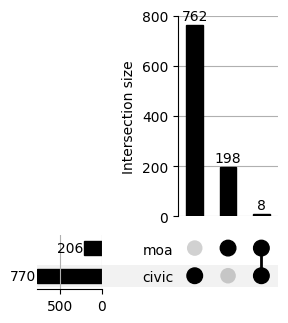

In [33]:
# Initialize unique groups for identifying uniqueness
unique_therapeutic_statements = list(data['statement'].unique())

therapeutic_statement_uniqueness = pd.DataFrame({'statements': unique_therapeutic_statements,
                                                'civic': None,
                                                'moa': None})

therapeutic_statement_uniqueness = calculate_uniqueness(therapeutic_statement_uniqueness, data,'statement')
upset_data = format_for_upset(therapeutic_statement_uniqueness,'statement')
plot(upset_data, show_counts=True)
# plt.savefig('gene_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### Concordance

In [87]:
# TODO: Make this whole section better and clean it up
# TODO: Have this report both by all sources but by independent source

data['statement_no_pred'] = data.apply(lambda row: (row['Variant'], row['Therapeutic'], row['Disease']), axis=1)
data[0:5]

,id,studyType,propositionType,description,alleleOriginQualifier,direction,predicate,Variant,Disease,Therapeutic,source,statement,statement_no_pred
0,civic.eid:238,Statement,VariantTherapeuticResponseProposition,The T790M mutation in EGFR has been shown to c...,somatic,supports,predictsResistanceTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,337525,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr...","(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, 33..."
1,civic.eid:1409,Statement,VariantTherapeuticResponseProposition,Phase 3 randomized clinical trial comparing ve...,somatic,supports,predictsSensitivityTo,ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L,Skin Melanoma,1147220,civic,"(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, pr...","(ga4gh:VA.j4XnsLZcdzDIYa5pvvXM7t1wn9OITr0L, 11..."
2,civic.eid:1592,Statement,VariantTherapeuticResponseProposition,Osimertinib has been approved for the treatmen...,somatic,supports,predictsSensitivityTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,1721560,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr...","(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, 17..."
3,civic.eid:1867,Statement,VariantTherapeuticResponseProposition,"Randomized, international, open-label, phase 3...",somatic,supports,predictsSensitivityTo,ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-,Lung Non-small Cell Carcinoma,1721560,civic,"(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, pr...","(ga4gh:VA.sMA9h8fzDi0RvweMlxtD0_Oi8B-JZ1V-, 17..."
4,civic.eid:2994,Statement,VariantTherapeuticResponseProposition,"On May 14, 2013, the U.S. Food and Drug Admini...",somatic,supports,predictsSensitivityTo,ga4gh:VA.S41CcMJT2bcd8R4-qXZWH1PoHWNtG2PZ,Lung Non-small Cell Carcinoma,337525,civic,"(ga4gh:VA.S41CcMJT2bcd8R4-qXZWH1PoHWNtG2PZ, pr...","(ga4gh:VA.S41CcMJT2bcd8R4-qXZWH1PoHWNtG2PZ, 33..."


In [88]:
concordance_counts = data['statement_no_pred'].value_counts().rename_axis('Unique Statements').reset_index(name='counts')
concordance_counts = concordance_counts[concordance_counts['counts']>1]

concordance_counts['agreement'] = None
for idx, row in concordance_counts.iterrows():
    tdf = data[data['statement_no_pred']==(row['Unique Statements'])]
    counts = count_predicate_occurrences(tdf)
    concordance_counts.at[idx, 'agreement'] = calculate_agreement_metric(counts)

concordance_counts

concordance_counts['Concordance'] = concordance_counts['agreement'].apply(lambda x: x==1)
graph = concordance_counts['Concordance'].value_counts().rename_axis('Concordance').reset_index(name='All Sources')
graph
# TODO: Clean up this graph, new_graph junk
new_graph = {
    'KB': ['All Sources'],
    '# Concordant': [graph.loc[graph['Concordance'] == True, 'All Sources'].values[0]],
    '# Discordant': [graph.loc[graph['Concordance'] == False, 'All Sources'].values[0]]
}
new_graph = pd.DataFrame(new_graph)
new_graph

,KB,# Concordant,# Discordant
0,All Sources,76,11


In [89]:
fig = go.Figure()

colors = ['#fefadd','#def8d3','#a0e5e6','#48c1da','#1e97c7','#3459a9']


fig.add_trace(go.Bar(
    name='Concordant',
    x=new_graph['KB'],
    y=new_graph['# Concordant'],
    marker_color=colors[0],
    width=[0.4]
))

fig.add_trace(go.Bar(
    name='Discordant',
    x=new_graph['KB'],
    y=new_graph['# Discordant'],
    marker_color=colors[1],
    width=[0.4]
))

fig.update_layout(
    barmode='stack',
    title='Concordance of Predicates in Variant Therapeutic Response Study Statements',
    xaxis_title='KB',
    yaxis_title='# Statements',
    legend_title='Concordance'
)

fig.show()


[Back to Top](#table-of-contents)


## Variant Diagnostic Study Statements

In [197]:
# TODO: Pull this in with an updated CDM

[Back to Top](#table-of-contents)


## Variant Oncogenicity Study Statements

In [198]:
# TODO: This does not exist in the Neo4j yet

[Back to Top](#table-of-contents)


## Cohort Allele Frequency Study Statements

In [199]:
# TODO: This does not exist in the Neo4j yet

[Back to Top](#table-of-contents)


## Experimental Variant Functional Impact Study Statements

In [200]:
# TODO: This does not exist in the Neo4j yet

[Back to Top](#table-of-contents)


## Individual Concept Uniqueness

### Diseases

In [16]:
q_all_diseases = """MATCH (s:Disease)
    RETURN properties(s) AS Disease
"""

result = execute_query(q_all_diseases)

data = []
for record in result:
    disease = record.get('Disease', {})
    row = {
        'id': disease.get('id', None),
        'label': disease.get('label', None),
        'normalizer_id': disease.get('normalizer_id', None)
    }
    data.append(row)


df = pd.DataFrame(data)
df['source'] = df['id'].apply(lambda x: x.split('.')[0])

df

,id,label,normalizer_id,source
0,civic.did:3,Acute Myeloid Leukemia,C3171,civic
1,civic.did:8,Lung Non-small Cell Carcinoma,C2926,civic
2,civic.did:19,Glioblastoma,C3058,civic
3,civic.did:11,Colorectal Cancer,C4978,civic
4,civic.did:206,Skin Melanoma,C3510,civic
...,...,...,...,...
136,moa.normalize.disease.ncit:C60781,Astrocytoma,C60781,moa
137,moa.normalize.disease.oncotree:LGGNOS,"Low-Grade Glioma, NOS",LGGNOS,moa
138,moa.normalize.disease.ncit:C3247,Myelodysplasia,C3247,moa
139,moa.normalize.disease.ncit:C3288,Oligodendroglioma,C3288,moa


125it [00:00, 3843.67it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

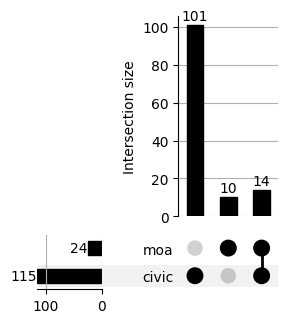

In [17]:
# Initialize unique groups for identifying uniqueness
unique_diseases = list(df['normalizer_id'].unique())

diseases = pd.DataFrame({'normalizer_ids': unique_diseases,
                                                'civic': None,
                                                'moa': None})

disease_uniqueness = calculate_uniqueness(diseases,df,'normalizer_id')
disease_proportions = disease_uniqueness # Copy of the DF for later
upset_data = format_for_upset(disease_uniqueness,'normalizer_id')
plot(upset_data, show_counts=True)
# plt.savefig('therapy_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### Genes

In [18]:
q_all_genes = """MATCH (g:Gene)
    RETURN properties(g) AS Gene
"""

result = execute_query(q_all_genes)

data = []
for record in result:
    gene = record.get('Gene', {})
    row = {
        'id': gene.get('id', None),
        'label': gene.get('label', None),
        'normalizer_id': gene.get('normalizer_id', None)
    }
    data.append(row)

df = pd.DataFrame(data)
df['source'] = df['id'].apply(lambda x: x.split('.')[0])


df

,id,label,normalizer_id,source
0,civic.gid:4244,ABCB1,HGNC:40,civic
1,civic.gid:7451,ABCG2,HGNC:74,civic
2,civic.gid:4,ABL1,HGNC:76,civic
3,civic.gid:101,ABL2,HGNC:77,civic
4,civic.gid:154,ACVR1,HGNC:171,civic
...,...,...,...,...
116,moa.normalize.gene.hgnc:9967,RET,HGNC:9967,moa
117,moa.normalize.gene.hgnc:15573,SETBP1,HGNC:15573,moa
118,moa.normalize.gene.hgnc:10768,SF3B1,HGNC:10768,moa
119,moa.normalize.gene.hgnc:10783,SRSF2,HGNC:10783,moa


91it [00:00, 3360.29it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate

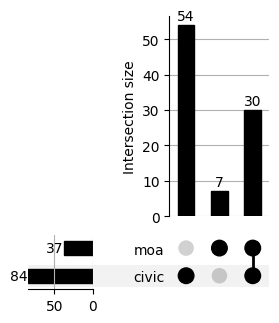

In [19]:
# Initialize unique groups for identifying uniqueness
unique_genes = list(df['normalizer_id'].unique())

genes = pd.DataFrame({'normalizer_ids': unique_genes,
                                                'civic': None,
                                                'moa': None})

gene_uniqueness = calculate_uniqueness(genes,df,'normalizer_id')
gene_proportions = gene_uniqueness # Copy of the DF for later
upset_data = format_for_upset(gene_uniqueness,'normalizer_id')
plot(upset_data, show_counts=True)
# plt.savefig('therapy_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### Therapies

In [20]:
q_all_therapies = """MATCH (t:Therapy) RETURN properties(t) AS Therapy
"""

result = execute_query(q_all_therapies)

data = []
for record in result:
    therapy = record.get('Therapy', {})
    if 'groupType' in therapy.keys():
        row = {
            'id': therapy.get('id', None),
            'label': None,
            'groupType': therapy.get('groupType', None),
            'normalizer_id': None
        }
    else:
        row = {
            'id': therapy.get('id', None),
            'label': therapy.get('label', None),
            'groupType': 'SingleAgent',
            'normalizer_id': therapy.get('normalizer_id', None)
        }
    data.append(row)
df = pd.DataFrame(data)
df['source'] = df['id'].apply(lambda x: x.split('.')[0])

df


,id,label,groupType,normalizer_id,source
0,civic.tid:15,Erlotinib,SingleAgent,337525,civic
1,civic.tid:11,Temozolomide,SingleAgent,37776,civic
2,civic.tid:16,Cetuximab,SingleAgent,318341,civic
3,civic.tid:4,Vemurafenib,SingleAgent,1147220,civic
4,civic.tid:19,Trametinib,SingleAgent,1425098,civic
...,...,...,...,...,...
324,moa.normalize.therapy.rxcui:2690647,Vorasidenib,SingleAgent,2690647,moa
325,moa.ctid:1TlyFhyafDojGZE0YzD6rCobJzbDaPUI,None,CombinationTherapy,None,moa
326,moa.normalize.therapy.rxcui:2691150,Lazertinib,SingleAgent,2691150,moa
327,moa.normalize.therapy.rxcui:2584304,Asciminib,SingleAgent,2584304,moa


174it [00:00, 3369.73it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

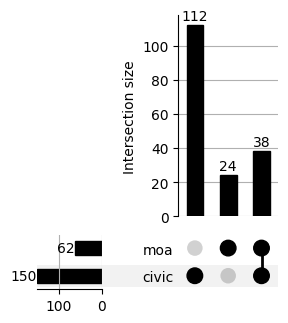

In [21]:
# Separate out Combination Therapies
data = df[df['groupType']=='SingleAgent']

# Initialize unique groups for identifying uniqueness
unique_therapeutic = list(data['normalizer_id'].unique())

therapeutics = pd.DataFrame({'normalizer_ids': unique_therapeutic,
                                                'civic': None,
                                                'moa': None})

therapy_uniqueness = calculate_uniqueness(therapeutics,data,'normalizer_id')
therapy_proportions = therapy_uniqueness # Copy of the DF for later
upset_data = format_for_upset(therapy_uniqueness,'normalizer_id')
plot(upset_data, show_counts=True)
# plt.savefig('therapy_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


### Variants

In [22]:
q_all_categorical_variants = """MATCH (c:CategoricalVariant)
MATCH (c)-[:HAS_DEFINING_CONTEXT]-(a:Allele) 
RETURN properties(c) AS CategoricalVariant, properties(a) AS Allele
"""

result = execute_query(q_all_categorical_variants)

data = []
for record in result:
    categorical_variant = record.get('CategoricalVariant', {})
    variant_allele = record.get('Allele', {})
    row = {
        'cat_id': categorical_variant.get('id', None),
        'cat_label': categorical_variant.get('label', None),
        'cat_variant_type': categorical_variant.get('variant_types', None),
        'cat_aliases': categorical_variant.get('aliases', None),
        'allele_id': variant_allele.get('id', None),
        'allele_label': variant_allele.get('label', None)
    }
    data.append(row)

df = pd.DataFrame(data)
df['source'] = df['cat_id'].apply(lambda x: x.split('.')[0])

df


,cat_id,cat_label,cat_variant_type,cat_aliases,allele_id,allele_label,source
0,civic.mpid:951,KIT D579del,"[{""id"": ""SO:0001825"", ""label"": ""conservative_i...","[""ASP579DEL""]",ga4gh:VA.9nu3YQ_Pi3fTdyJJEI4RBgRvMd17B_DL,D579del,civic
1,civic.mpid:966,BRAF G469A,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""GLY469ALA""]",ga4gh:VA.G9qFC7EGgPP3NnedaubgQktxNd-vilZD,G469A,civic
2,civic.mpid:973,EGFR G719A,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""GLY719ALA""]",ga4gh:VA.DkV6ap7GeZ4vsV44rvC_J-L8q4zuwFVa,G719A,civic
3,civic.mpid:1080,BRAF G464V,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""GLY464VAL""]",ga4gh:VA.ZW1uZLxfoQiVJZ7zBirH-IGd2GwCK-xp,G464V,civic
4,civic.mpid:1152,PIK3CA R93W,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""ARG93TRP""]",ga4gh:VA.qZEHGjpMxRDcP8EtowQPhBSwvg_qDnSS,R93W,civic
...,...,...,...,...,...,...,...
574,civic.mpid:867,NRAS Q61H,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""GLN61HIS""]",ga4gh:VA.sUQrnY4jvb7whQHgnS6rkx08Lb44wowM,Q61H,civic
575,civic.mpid:870,NRAS G13R,"[{""id"": ""SO:0001583"", ""label"": ""missense_varia...","[""GLY13ARG""]",ga4gh:VA.B7zZTxypiwSWZpc4LASs-CZL50acW3wA,G13R,civic
576,civic.mpid:923,KIT K550_K558del,"[{""id"": ""SO:0001822"", ""label"": ""inframe_deleti...","[""KPMYEVQWK550-558DEL""]",ga4gh:VA.nzSpvSgC8dJnQKVhJNMSfnbQyRtkwXwn,K550_K558del,civic
577,civic.mpid:938,KIT K558_V559del,None,None,ga4gh:VA.gYpuC4qY7vTVRpSq9feuE3_LFR8l2NZN,K558_V559del,civic


525it [00:00, 2923.65it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

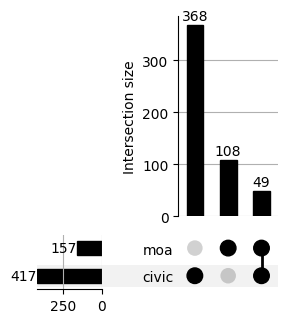

In [23]:
# Initialize unique groups for identifying uniqueness
unique_variant = list(df['allele_id'].unique())

variants = pd.DataFrame({'allele_ids': unique_variant,
                                                'civic': None,
                                                'moa': None})

variant_uniqueness = calculate_uniqueness(variants,df,'allele_id')
variant_proportions = variant_uniqueness # Copy of the DF for later
upset_data = format_for_upset(variant_uniqueness,'allele_id')
plot(upset_data, show_counts=True)
# plt.savefig('therapy_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


In [24]:
df['source'].value_counts()

source
civic    419
moa      160
Name: count, dtype: int64

### All Plot

In [25]:
# TODO: Make this work

# Count number of sources True
gene_proportions["true_count"] = gene_proportions.iloc[:, 0:].sum(axis=1)
therapy_proportions["true_count"] = therapy_proportions.iloc[:, 0:].sum(axis=1)
disease_proportions["true_count"] = disease_proportions.iloc[:, 0:].sum(axis=1)
variant_proportions["true_count"] = variant_proportions.iloc[:, 0:].sum(axis=1)

graph = pd.DataFrame({'# of KBs': [], 'Records': [], 'proportion': [], 'Record Type': []})

# Value Counts & Combine
tdf = gene_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Gene'
graph = pd.concat([graph,tdf])

tdf = therapy_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Therapy'
graph = pd.concat([graph,tdf])

tdf = disease_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Disease'
graph = pd.concat([graph,tdf])

tdf = variant_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Variant'
graph = pd.concat([graph,tdf])

# Plotly graph objects for the stacked bar
# fig = go.Figure()
colors = ['#fefadd','#def8d3','#a0e5e6','#48c1da','#1e97c7','#3459a9']

# Plotly graph objects for the stacked bar
fig = go.Figure()

# Adding each segment as part of a stacked bar
for i, row in graph.iterrows():
    fig.add_trace(go.Bar(
        name=f'{row["# of KBs"]} KBs',
        x=[row['Record Type']],  # single category for now
        y=[row['proportion']],
        marker_color=colors[i],  # using Plotly's qualitative colors
        width=[0.4]
    ))

# Update layout to show proportions as percentage
fig.update_layout(
    barmode='stack',
    title='Element uniqueness across KBs',
    xaxis_title='Category',
    yaxis_title='Proportion',
    yaxis=dict(tickformat=".2"),
    legend_title='# of KBs'
)

fig.show()

# fig.write_image("v1_uniqueness.png", width=990, height=540, scale=3)

[Back to Top](#table-of-contents)
